preprocessing: data cleaning

In [1]:
import os
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def main():
    try:
        directory = 'data/filterme-origin'
        if not os.path.exists(directory):
            print("Invalid directory path. Please ensure the directory exists.")
            return
        extension_count = count_files_with_same_extension(directory)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

data/filterme-origin/labels:
- with .txt files: 8044
data/filterme-origin/images:
- with .jpg files: 8044


total active labeling

In [8]:
import os

# Base directory
base_dir = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/'

# Create a dictionary to hold file extension and counts
file_counts = {}

# Traverse through directories
for i in range(10000):  # Increase range if have more directories
    if i == 0:
        curr_dir = os.path.join(base_dir, 'activ-labeling.v1i.yolov8')
    else:
        curr_dir = os.path.join(base_dir, f'activ-labeling{i}.v1i.yolov8')

    # Check if directory exists
    if not os.path.exists(curr_dir):
        break

    # Walk through all directories and subdirectories
    for dirpath, dirnames, filenames in os.walk(curr_dir):
        # Count file extensions
        for file in filenames:
            _, ext = os.path.splitext(file)
            file_counts[ext] = file_counts.get(ext, 0) + 1

# Print the count of each file extension
for ext, count in file_counts.items():
    print(f'Total {ext} files: {count}')

Total .txt files: 256
Total .yaml files: 4
Total .jpg files: 248


In [11]:
import os
from collections import defaultdict

def count_files_in_directories(base_dir, directories):
    ext_dict = defaultdict(int)

    for dir_name in directories:
        folder_path = os.path.join(base_dir, dir_name)
        if os.path.exists(folder_path):
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    ext = os.path.splitext(file)[-1]
                    ext_dict[ext] += 1

    return ext_dict

base_dir = 'faiss/active-learning/remove-by-hand-trial2/set1/manually'
directories = ["activ-labeling.v1i.yolov8"]

# Assuming maximum 100, adjust if needed
for i in range(1, 100):
    directories.append(f'activ-labeling{i}.v1i.yolov8')

ext_dict = count_files_in_directories(base_dir, directories)
for ext, count in ext_dict.items():
    print(f'Total {ext} files: {count}')

Total .txt files: 256
Total .yaml files: 4
Total .jpg files: 248


auto check and increase the number of existed exclude directories list/collection/array

In [1]:
import os
import re
import glob
import numpy as np
import torch
import faiss
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import shutil

# Limit PyTorch to 24 threads
torch.set_num_threads(24)

# Function to load an image and return a torch tensor
def load_image(image_path):
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])
    img_t = transform(img)
    return img_t

class ImageDataset(Dataset):
    def __init__(self, root_dir, exclude_files):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and f not in exclude_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img_tensor = load_image(img_path)
        return img_tensor, img_path

def generate_exclude_dirs(pattern, base_exclude_dir):
    # Get a list of all matching directories
    all_dirs = glob.glob(pattern)

    # Extract the numbers from these directories
    numbers = sorted([int(re.search(r"\d+", d).group()) for d in all_dirs if re.search(r"\d+", d)])

    # Exclude the highest number
    numbers = numbers[:-1]

    # Generate the list of exclude directories
    exclude_dirs = [base_exclude_dir.format(number=n) for n in numbers]

    # Add base exclude directory
    exclude_dirs.append('faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling.v1i.yolov8/train/images')

    return exclude_dirs

def get_exclude_files(exclude_dirs):
    exclude_files = []
    for dir in exclude_dirs:
        exclude_files.extend([f for f in os.listdir(dir) if f.endswith('.jpg')])
    return exclude_files

# Define directories
reference_image_path = 'data/filterme-origin/images/Mummies-2023-STAGATV-COM_frame_25_out.jpg'
search_dir = 'data/filterme-origin/images'

base_exclude_dir = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{number}.v1i.yolov8/train/images'
pattern = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling*.v1i.yolov8/train/images'
exclude_dirs = generate_exclude_dirs(pattern, base_exclude_dir)
exclude_files = get_exclude_files(exclude_dirs)

# Auto-increment the directory number
trial_number = 1
save_dir = f'faiss/same-trial{trial_number}/'
while os.path.exists(save_dir):
    trial_number += 1
    save_dir = f'faiss/same-trial{trial_number}/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Saving images to directory: {save_dir}")

# Load reference image
reference_img = load_image(reference_image_path).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True)
model = model.to(device)
model.eval()

model = torch.nn.Sequential(*(list(model.children())[:-1]))

reference_img = reference_img.to(device)
reference_vector = model(reference_img).cpu().detach().numpy().flatten()

image_vectors = []
image_paths = []

# Initialize the dataset with exclusion list
dataset = ImageDataset(search_dir, exclude_files)
dataloader = DataLoader(dataset, batch_size=64, num_workers=24)

for images, paths in tqdm(dataloader):
    images = images.to(device)
    vectors = model(images).cpu().detach().numpy()
    vectors = vectors.reshape(vectors.shape[0], -1)  # Reshape the vectors
    image_vectors.extend(vectors)
    image_paths.extend(paths)

image_vectors = np.asarray(image_vectors).astype('float32')

faiss.normalize_L2(image_vectors)

res = faiss.StandardGpuResources()  # use a single GPU
index = faiss.IndexFlatL2(image_vectors.shape[1])
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
gpu_index.add(image_vectors)  # add vectors to the index

reference_vector = np.asarray(reference_vector).astype('float32')
reference_vector = np.expand_dims(reference_vector, axis=0)
faiss.normalize_L2(reference_vector)

k = 128  # We want to see k nearest neighbors
D, I = gpu_index.search(reference_vector, k)

print('Similar images are:')
for i in I[0]:
    print(image_paths[i])
    shutil.copy2(image_paths[i], os.path.join(save_dir, os.path.basename(image_paths[i])))

Saving images to directory: faiss/same-trial12/


/home/aivn12gb/miniconda3/envs/faiss/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aivn12gb/miniconda3/envs/faiss/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 124/124 [00:23<00:00,  5.28it/s]


Similar images are:
data/filterme-origin/images/Mummies-2023-STAGATV-COM_frame_25_out.jpg
data/filterme-origin/images/Otakudesu.net_BW_GGS--13_End_360p_frame_237_out.jpg
data/filterme-origin/images/Otakudesu_BlndS-12_360p_END_frame_698_out_jpg.rf.1d41977141e11ac35bdf73f477cbf642.jpg
data/filterme-origin/images/Otakudesu-net_BW_GGS-13_End_360p_frame_684_out_jpg.rf.12dac04b780882095f8e2f48459a481b.jpg
data/filterme-origin/images/Otakudesu.net_BW_GGS--13_End_360p_frame_479_out.jpg
data/filterme-origin/images/Otakudesu-net_BLk-24_End_360p_frame_122_out_jpg.rf.106c742f3aba3b7f45d5f998afc86084.jpg
data/filterme-origin/images/Otakudesu.net_BW_GGS--13_End_360p_frame_705_out.jpg
data/filterme-origin/images/Otakudesu.net_BW_GGS--13_End_360p_frame_563_out.jpg
data/filterme-origin/images/Otakudesu.net_BW_GGS--13_End_360p_frame_726_out.jpg
data/filterme-origin/images/Mummies-2023-STAGATV-COM_frame_5368_out.jpg
data/filterme-origin/images/Otakudesu_BlndS-12_360p_END_frame_144_out_jpg.rf.6b121654ded8

detect for filter out those image does not have human in there

In [2]:
import os
import wandb
from ultralytics import YOLO
import shutil
import re

wandb_run = wandb.init(project="yolo-filter3", entity='tuanngoc')

model = YOLO('wandb/run-20230713_010242-o90i1zwp/files/train/weights/last.pt')

base_dir = 'faiss/'
source_subdir = 'same-trial'
save_subdir = 'human-exp'

min_confidence = 0.75  # Adjust this as necessary

# Get list of directories in 'faiss' that match 'same-trial{number}'
source_dirs = [d for d in os.listdir(base_dir) if re.match(rf"{source_subdir}\d+", d)]

# Extract trial numbers and get the highest
source_numbers = [int(re.findall(r"\d+", d)[0]) for d in source_dirs]
max_source_number = max(source_numbers)

source_dir = os.path.join(base_dir, f"{source_subdir}{max_source_number}")

# Generate save_dir by finding the existing max number and adding 1
save_dirs = [d for d in os.listdir(base_dir) if re.match(rf"{save_subdir}\d+", d)]
save_numbers = [int(re.findall(r"\d+", d)[0]) for d in save_dirs] if save_dirs else [0]
next_save_number = max(save_numbers) + 1

save_dir = os.path.join(base_dir, f"{save_subdir}{next_save_number}")

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

for image_file in image_files:
    image_path = os.path.join(source_dir, image_file)

    results_gen = model.predict(image_path, stream=True, imgsz=640, save=False, save_txt=False)

    human_detected = False

    for results in results_gen:
        if len(results.boxes) > 0:
            for result_index, result in enumerate(results):
                boxes = result.boxes  # Boxes object for bbox outputs
                box_coords = boxes.xyxy  # box with xyxy format, (N, 4)

                for i in range(box_coords.shape[0]):
                    x1, y1, x2, y2 = box_coords[i]  # Get box coordinates
                    class_id = boxes.cls[i]  # Get class id
                    objectness_score = boxes.conf[i]  # Get confidence score

                    # Check if the confidence score is above a certain threshold
                    if objectness_score >= min_confidence:
                        human_detected = True

                        wandb.log({
                            "image number": result_index,
                            "bounding box": {
                                "position": {
                                    "minX": x1.item(),
                                    "maxX": x2.item(),
                                    "minY": y1.item(),
                                    "maxY": y2.item()
                                },
                                "class_id": class_id.item(),
                                "class_name": "Human",
                                "box_caption": "Human",
                                "domain": "pixel",
                                "scores": {
                                    "objectness_score": objectness_score.item(),
                                }
                            },
                        })

    if human_detected:
        shutil.copy2(image_path, os.path.join(save_dir, image_file))
    else:
        os.remove(image_path)

wandb_run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tuanngoc. Use `wandb login --relogin` to force relogin



image 1/1 /home/aivn12gb/yolov8_domain_adaption_evn/faiss/same-trial12/Otakudesu_BlndS--12_360p_END_frame_632_out.jpg: 384x640 2 Humans, 21.6ms
Speed: 1.3ms preprocess, 21.6ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/aivn12gb/yolov8_domain_adaption_evn/faiss/same-trial12/Mummies-2023-STAGATV-COM_frame_3413_out.jpg: 384x640 1 Human, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/aivn12gb/yolov8_domain_adaption_evn/faiss/same-trial12/Otakudesu.net_BW_GGS--13_End_360p_frame_1152_out.jpg: 384x640 1 Human, 17.1ms
Speed: 0.9ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/aivn12gb/yolov8_domain_adaption_evn/faiss/same-trial12/Otakudesu_BlndS--12_360p_END_frame_726_out.jpg: 384x640 2 Humans, 15.9ms
Speed: 0.9ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/aivn12gb/yolov

image number,▁▁▁▁▁▁▆▁▁▁▁▃▁▃▃█▃▁▁▁▁▁▁▃▁▁▁▁▁▃▃▁▁▁▁▁▁▁▁▁
image number,0


In [3]:
import os
import re
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def find_latest_experiment(directory):
    max_number = -1
    latest_experiment = None
    for dir in os.listdir(directory):
        match = re.match(r"human-exp(\d+)$", dir)
        if match:
            number = int(match.group(1))
            if number > max_number:
                max_number = number
                latest_experiment = os.path.join(directory, dir)
    return latest_experiment

def main():
    try:
        directory = "faiss"  # the base directory containing the human-exp{number} directories
        latest_experiment = find_latest_experiment(directory)
        if not latest_experiment:
            print(f"No 'human-exp{{number}}' directories found in {directory}.")
            return
        extension_count = count_files_with_same_extension(latest_experiment)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

faiss/human-exp7:
- with .jpg files: 72


move label txt and image jpg to the new human-exp directory

In [4]:
import os
import shutil
import re

# Base directory
base_dir = 'faiss/'

# Sub directory prefix
save_subdir = 'human-exp'

# Generate save_dir by finding the existing max number
save_dirs = [d for d in os.listdir(base_dir) if re.match(rf"{save_subdir}\d+", d)]
save_numbers = [int(re.findall(r"\d+", d)[0]) for d in save_dirs] if save_dirs else [0]
highest_save_number = max(save_numbers)

# Construct the source directory using the highest save number
source_directory = os.path.join(base_dir, f"{save_subdir}{highest_save_number}")

image_directory = os.path.join(source_directory, 'images')
label_directory = os.path.join(source_directory, 'labels')
txt_directory = 'data/filterme-origin/labels'

# Create target directories if they don't exist
os.makedirs(image_directory, exist_ok=True)
os.makedirs(label_directory, exist_ok=True)

# Create 'classes.txt' in source_directory with 'Human' as content
classes_file_path = os.path.join(source_directory, 'classes.txt')
with open(classes_file_path, 'w') as classes_file:
    classes_file.write('Human\n')

# Move files from source to image_directory
for file in os.listdir(source_directory):
    if file.endswith('.jpg'):
        shutil.move(os.path.join(source_directory, file), image_directory)

# Copy corresponding txt files from txt_directory to label_directory
for file in os.listdir(txt_directory):
    if file.endswith('.txt'):
        corresponding_image_file = os.path.join(image_directory, file.replace('.txt', '.jpg'))
        if os.path.isfile(corresponding_image_file):
            shutil.copy(os.path.join(txt_directory, file), label_directory)

# Remove non-corresponding jpg files in image_directory
for file in os.listdir(image_directory):
    if file.endswith('.jpg'):
        corresponding_label_file = os.path.join(label_directory, file.replace('.jpg', '.txt'))
        if not os.path.isfile(corresponding_label_file):
            os.remove(os.path.join(image_directory, file))

# Remove non-corresponding txt files in label_directory
for file in os.listdir(label_directory):
    if file.endswith('.txt'):
        corresponding_image_file = os.path.join(image_directory, file.replace('.txt', '.jpg'))
        if not os.path.isfile(corresponding_image_file):
            os.remove(os.path.join(label_directory, file))

In [5]:
import os
import re
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def find_latest_experiment(directory):
    max_number = -1
    latest_experiment = None
    for dir in os.listdir(directory):
        match = re.match(r"human-exp(\d+)$", dir)
        if match:
            number = int(match.group(1))
            if number > max_number:
                max_number = number
                latest_experiment = os.path.join(directory, dir)
    return latest_experiment

def main():
    try:
        directory = "faiss"  # the base directory containing the human-exp{number} directories
        latest_experiment = find_latest_experiment(directory)
        if not latest_experiment:
            print(f"No 'human-exp{{number}}' directories found in {directory}.")
            return
        extension_count = count_files_with_same_extension(latest_experiment)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

faiss/human-exp7:
- with .txt files: 1
faiss/human-exp7/labels:
- with .txt files: 72
faiss/human-exp7/images:
- with .jpg files: 72


after manually label by hand, run this code

better unzip when watching changes

In [ ]:
!pip install watchdog

  Using cached watchdog-3.0.0-py3-none-manylinux2014_x86_64.whl (82 kB)


In [6]:
import glob
import os
import re
import shutil
import zipfile
from pathlib import Path

# determine user's home directory
home_dir = str(Path.home())

# set the directories
src_dir = os.path.join(home_dir, "Downloads")
file_pattern = "activ-labeling*.v1i.yolov8.zip"
dst_dir = os.path.join(home_dir, "yolov8_domain_adaption_evn/faiss/active-learning/remove-by-hand-trial2/set1/manually")

files = glob.glob(os.path.join(src_dir, file_pattern))

if not files:
    print("No files found")
else:
    numbers = [int(re.search(r'activ-labeling(\d+).v1i.yolov8.zip', f).group(1)) for f in files]

    highest_number = max(numbers)

    src_file = os.path.join(src_dir, f"activ-labeling{highest_number}.v1i.yolov8.zip")

    os.makedirs(dst_dir, exist_ok=True)
    dst_file = os.path.join(dst_dir, os.path.basename(src_file))
    shutil.move(src_file, dst_file)
    print(f"File {src_file} moved successfully to {dst_file}")

    unzip_dir = os.path.join(dst_dir, os.path.splitext(os.path.basename(dst_file))[0])
    os.makedirs(unzip_dir, exist_ok=True)
    with zipfile.ZipFile(dst_file, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"File {dst_file} unzipped successfully in {unzip_dir}")

No files found


second approach(aka with the smaller data) after manually labeling

better code handling warning log

No match found in directory: faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling.v1i.yolov8/train/images
1/1 [==============================] - 0s 310ms/step
Processed image Otakudesu_BlndS-12_360p_END_frame_469_out_jpg.rf.ea7923e7bac5648b583c331473c0b30b.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Mummies-2023-STAGATV-COM_frame_5583_out_jpg.rf.afc3c1611c18c9c3017680b2c3f21039.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu_BlndS-12_360p_END_frame_667_out_jpg.rf.0bac2d4621f20e0efe3967f42c33bcf3.jpg
1/1 [==============================] - 0s 12ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_846_out_jpg.rf.8c0973884b1eaaa60587c67a502b04b3.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_716_out_jpg.rf.fce3f8b449573e726402e878ce748196.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360

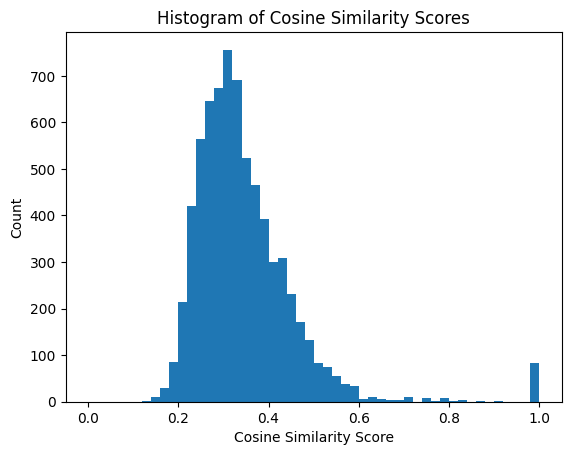

Duplicates will be moved to: faiss/duplicate/trial18/
Found 0 duplicates.


In [13]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import glob
import re

# Load VGG16 model for feature extraction
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to load and preprocess image
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to extract features from image
def extract_features(img):
    feature = model.predict(img)
    return np.squeeze(feature)

# Function to move duplicate images to another directory
def move_duplicates(duplicates_dict, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for key, values in duplicates_dict.items():
        for file_path in values:
            try:
                shutil.move(file_path, target_dir)
            except Exception as e:
                print(f"Could not move image {file_path}. Error: {e}")

# Identify the directory with the highest number
dir_pattern = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling*.v1i.yolov8/train/images'
dir_list = glob.glob(dir_pattern)

numbers = []
for dir in dir_list:
    match = re.search(r'activ-labeling(\d+)', dir)
    if match is not None:
        numbers.append(int(match.group(1)))
    else:
        print(f"No match found in directory: {dir}")
highest_number = max(numbers)

# source directory
src_dir = f'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images'

# Lists to hold image features and paths
features = []
paths = []

# Iterate over images in source directory
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        try:
            image_path = os.path.join(src_dir, filename)
            img = load_and_process_image(image_path)
            feature = extract_features(img)
            features.append(feature)
            paths.append(image_path)
            print(f"Processed image {filename}")
        except Exception as e:
            print(f"Could not process image {filename}. Error: {e}")

# Convert list of features to array
features = np.array(features)

# Calculate pairwise cosine similarity
cosine_similarities = 1 - squareform(pdist(features, metric='cosine'))

# Prepare histogram and count each score
bins = np.arange(0, 1.01, 0.01) # adjust the range here as needed
hist, bin_edges = np.histogram(cosine_similarities.flatten(), bins=bins)

score_counts = dict(zip([round(b, 2) for b in bin_edges[:-1]], hist))

# Print the counts
for score, count in score_counts.items():
    print(f"Number of images with score {score}: {count}")

# Plot a histogram of the cosine similarity scores
plt.hist(cosine_similarities.flatten(), bins=50, range=(0.0, 1.0))
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Count')
plt.show()

# Get indices of pairs with cosine similarity above a certain threshold (e.g., 0.95)
indices = np.where(cosine_similarities > 0.95)

# Get the unique duplicate paths (considering each pair once)
duplicates_dict = defaultdict(list)
handled_images = set()
for i in range(len(indices[0])):
    if indices[0][i] < indices[1][i]:  # consider each pair once
        img1 = paths[indices[0][i]]
        img2 = paths[indices[1][i]]
        if img2 not in handled_images:  # avoid adding an image that has already been identified as a duplicate
            duplicates_dict[img1].append(img2)
            handled_images.add(img2)

# Check for any existing directory with the same name
trial_number = 1
save_dir = f'faiss/duplicate/trial{trial_number}/'
while os.path.exists(save_dir):
    trial_number += 1
    save_dir = f'faiss/duplicate/trial{trial_number}/'

# Print the directory path and number of duplicates found
print(f"Duplicates will be moved to: {save_dir}")
print(f"Found {sum([len(val) for val in duplicates_dict.values()])} duplicates.")

# Move duplicates to a new directory
move_duplicates(duplicates_dict, save_dir)

automated threshold selection

2023-08-07 18:07:28.397834: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 18:07:28.561298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 18:07:29.069161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-07 18:07:29.725224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

No match found in directory: faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling.v1i.yolov8/train/images


2023-08-07 18:07:32.275461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Processed image Otakudesu_BlndS-12_360p_END_frame_469_out_jpg.rf.ea7923e7bac5648b583c331473c0b30b.jpg
1/1 [==============================] - 0s 18ms/step
Processed image Mummies-2023-STAGATV-COM_frame_5583_out_jpg.rf.afc3c1611c18c9c3017680b2c3f21039.jpg
1/1 [==============================] - 0s 8ms/step
Processed image Otakudesu_BlndS-12_360p_END_frame_667_out_jpg.rf.0bac2d4621f20e0efe3967f42c33bcf3.jpg
1/1 [==============================] - 0s 8ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_846_out_jpg.rf.8c0973884b1eaaa60587c67a502b04b3.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_716_out_jpg.rf.fce3f8b449573e726402e878ce748196.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_628_out_jpg.rf.295435da4c04b41976f3075ea2d64a35.jpg
1/1 [==============================] - 0s 8ms/step
Processed image Mu

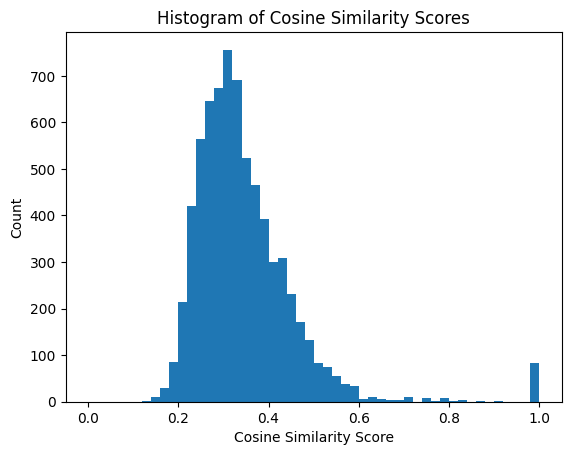

Optimal cosine similarity threshold: 0.4825454285646533
Duplicates will be moved to: faiss/duplicate/trial23/
Found 54 duplicates.


In [2]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import glob
import re
import numpy.matlib

# Load VGG16 model for feature extraction
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to load and preprocess image
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to extract features from image
def extract_features(img):
    feature = model.predict(img)
    return np.squeeze(feature)

# Function to move duplicate images to another directory
def move_duplicates(duplicates_dict, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for key, values in duplicates_dict.items():
        for file_path in values:
            try:
                shutil.move(file_path, target_dir)
            except Exception as e:
                print(f"Could not move image {file_path}. Error: {e}")

# Identify the directory with the highest number
dir_pattern = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling*.v1i.yolov8/train/images'
dir_list = glob.glob(dir_pattern)

numbers = []
for dir in dir_list:
    match = re.search(r'activ-labeling(\d+)', dir)
    if match is not None:
        numbers.append(int(match.group(1)))
    else:
        print(f"No match found in directory: {dir}")
highest_number = max(numbers)

# source directory
src_dir = f'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images'

# Lists to hold image features and paths
features = []
paths = []

# Iterate over images in source directory
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        try:
            image_path = os.path.join(src_dir, filename)
            img = load_and_process_image(image_path)
            feature = extract_features(img)
            features.append(feature)
            paths.append(image_path)
            print(f"Processed image {filename}")
        except Exception as e:
            print(f"Could not process image {filename}. Error: {e}")

# Convert list of features to array
features = np.array(features)

# Calculate pairwise cosine similarity
cosine_similarities = 1 - squareform(pdist(features, metric='cosine'))

# Flatten the cosine similarities and sort in descending order
sorted_cosine_similarities = np.sort(cosine_similarities.flatten())[::-1]

# Plot a histogram of the cosine similarity scores
plt.hist(sorted_cosine_similarities, bins=50, range=(0.0, 1.0))
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Count')
plt.show()

# Define the elbow finding function
def find_elbow(data):
    # normalize data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # create coordinates for line
    n_points = len(data)
    all_coords = np.vstack((range(n_points), data)).T
    
    # get vector between first and last point
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    # calculate vector from first point to all points
    vec_from_first = all_coords - all_coords[0]
    
    # calculate orthogonal vector
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    
    # find distance to line
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    # find elbow point
    elbow_index = np.argmax(dist_to_line)
    
    return elbow_index

# Find the elbow in the sorted cosine similarities
elbow_index = find_elbow(sorted_cosine_similarities)

# Use the cosine similarity at the elbow point as the threshold
cosine_threshold = sorted_cosine_similarities[elbow_index]

print(f"Optimal cosine similarity threshold: {cosine_threshold}")

# Get indices of pairs with cosine similarity above the threshold
indices = np.where(cosine_similarities > cosine_threshold)

# Get the unique duplicate paths (considering each pair once)
duplicates_dict = defaultdict(list)
handled_images = set()
for i in range(len(indices[0])):
    if indices[0][i] < indices[1][i]:  # consider each pair once
        img1 = paths[indices[0][i]]
        img2 = paths[indices[1][i]]
        if img2 not in handled_images:  # avoid adding an image that has already been identified as a duplicate
            duplicates_dict[img1].append(img2)
            handled_images.add(img2)

# Check for any existing directory with the same name
trial_number = 1
save_dir = f'faiss/duplicate/trial{trial_number}/'
while os.path.exists(save_dir):
    trial_number += 1
    save_dir = f'faiss/duplicate/trial{trial_number}/'

# Print the directory path and number of duplicates found
print(f"Duplicates will be moved to: {save_dir}")
print(f"Found {sum([len(val) for val in duplicates_dict.values()])} duplicates.")

# Move duplicates to a new directory
move_duplicates(duplicates_dict, save_dir)

third approach(for large dataset) using LSH

In [2]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import glob
import re
from datasketch import MinHash, MinHashLSH

# Load VGG16 model for feature extraction
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to load and preprocess image
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to extract features from image
def extract_features(img):
    feature = model.predict(img)
    return np.squeeze(feature)

# Function to move duplicate images to another directory
def move_duplicates(duplicates_dict, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for key, values in duplicates_dict.items():
        for file_path in values:
            try:
                shutil.move(file_path, target_dir)
            except Exception as e:
                print(f"Could not move image {file_path}. Error: {e}")

# Identify the directory with the highest number
dir_pattern = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling*.v1i.yolov8/train/images'
dir_list = glob.glob(dir_pattern)

numbers = []
for dir in dir_list:
    match = re.search(r'activ-labeling(\d+)', dir)
    if match is not None:
        numbers.append(int(match.group(1)))
    else:
        print(f"No match found in directory: {dir}")
highest_number = max(numbers)

# source directory
src_dir = f'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images'

# Initialize MinHashLSH
lsh = MinHashLSH(threshold=0.95, num_perm=128)

# We will keep track of minhash objects along with their keys in a dictionary
minhash_dict = dict()

# Iterate over images in source directory
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        try:
            image_path = os.path.join(src_dir, filename)
            img = load_and_process_image(image_path)
            feature = extract_features(img)
            minhash = MinHash(num_perm=128)
            for val in feature:
                minhash.update(str(val).encode('utf8'))
            lsh.insert(image_path, minhash)
            minhash_dict[image_path] = minhash  # Keep track of minhash objects
            print(f"Processed image {filename}")
        except Exception as e:
            print(f"Could not process image {filename}. Error: {e}")

# Check for any existing directory with the same name
trial_number = 1
save_dir = f'faiss/duplicate/trial{trial_number}/'
while os.path.exists(save_dir):
    trial_number += 1
    save_dir = f'faiss/duplicate/trial{trial_number}/'

# Print the directory path and number of duplicates found
print(f"Duplicates will be moved to: {save_dir}")

# Find and move duplicates
duplicates_dict = defaultdict(list)
num_duplicates = 0
for key in lsh.keys:
    # We retrieve the MinHash object from our dictionary instead
    minhash = minhash_dict[key]
    result = lsh.query(minhash)
    if len(result) > 1:
        num_duplicates += len(result) - 1  # subtract one because the image itself is always in the result
        duplicates_dict[key] = result[1:]  # skip the first result because it's the image itself

print(f"Found {num_duplicates} duplicates.")
move_duplicates(duplicates_dict, save_dir)

No match found in directory: faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling.v1i.yolov8/train/images
1/1 [==============================] - 0s 54ms/step
Processed image Otakudesu_BlndS-12_360p_END_frame_469_out_jpg.rf.ea7923e7bac5648b583c331473c0b30b.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Mummies-2023-STAGATV-COM_frame_5583_out_jpg.rf.afc3c1611c18c9c3017680b2c3f21039.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu_BlndS-12_360p_END_frame_667_out_jpg.rf.0bac2d4621f20e0efe3967f42c33bcf3.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_846_out_jpg.rf.8c0973884b1eaaa60587c67a502b04b3.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_frame_716_out_jpg.rf.fce3f8b449573e726402e878ce748196.jpg
1/1 [==============================] - 0s 8ms/step
Processed image Otakudesu-net_BW_GGS-13_End_360p_

repairing data(remove the similarity) in 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images/', after running the second approach for filtering similar images groups

better logging information from the previous reparing files in 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images/':


In [3]:
import os

def get_highest_trial(directory):
    trial_numbers = []
    for dir_name in os.listdir(directory):
        if "trial" in dir_name:
            try:
                trial_number = int(dir_name.replace("trial", ""))
                trial_numbers.append(trial_number)
            except ValueError:
                print(f"Cannot convert {dir_name} to trial number.")
                continue
    return max(trial_numbers) if trial_numbers else None

def get_highest_number(directory):
    numbers = []
    for dir_name in os.listdir(directory):
        if "activ-labeling" in dir_name:
            try:
                number = int(dir_name.split(".")[0].replace("activ-labeling", ""))
                numbers.append(number)
            except ValueError:
                print(f"Cannot convert {dir_name} to number.")
                continue
    return max(numbers) if numbers else None

# Call the functions to get the highest trial number and highest number
trial_directory = os.path.join(os.getcwd(), 'faiss/duplicate/')
highest_trial = get_highest_trial(trial_directory)
print(f"The highest trial number is: {highest_trial}")

number_directory = os.path.join(os.getcwd(), 'faiss/active-learning/remove-by-hand-trial2/set1/manually/')
highest_number = get_highest_number(number_directory)
print(f"The highest number is: {highest_number}")

# Remove coincidental image files
if highest_number is not None and highest_trial is not None:
    duplicate_dir = os.path.join(os.getcwd(), f'faiss/duplicate/trial{highest_trial}/')
    target_dir = os.path.join(os.getcwd(), f'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images/')

    duplicate_files = set(os.listdir(duplicate_dir))
    print(f"Total duplicate files: {len(duplicate_files)}")

    for file_name in os.listdir(target_dir):
        if file_name in duplicate_files:
            try:
                os.remove(os.path.join(target_dir, file_name))
                print(f"Removed coincidental image file: {file_name}")
            except Exception as e:
                print(f"Could not remove image {file_name}. Error: {e}")
        else:
            print(f"File {file_name} is not a duplicate.")
else:
    print("Cannot find highest trial number or highest number. Please check my directories.")

The highest trial number is: 23
Cannot convert activ-labeling.v1i.yolov8.zip to number.
Cannot convert activ-labeling.v1i.yolov8 to number.
The highest number is: 4
Total duplicate files: 54
File Otakudesu_BlndS-12_360p_END_frame_469_out_jpg.rf.ea7923e7bac5648b583c331473c0b30b.jpg is not a duplicate.
File Mummies-2023-STAGATV-COM_frame_5583_out_jpg.rf.afc3c1611c18c9c3017680b2c3f21039.jpg is not a duplicate.
File Otakudesu_BlndS-12_360p_END_frame_667_out_jpg.rf.0bac2d4621f20e0efe3967f42c33bcf3.jpg is not a duplicate.
File Otakudesu-net_BW_GGS-13_End_360p_frame_846_out_jpg.rf.8c0973884b1eaaa60587c67a502b04b3.jpg is not a duplicate.
File Otakudesu-net_BW_GGS-13_End_360p_frame_716_out_jpg.rf.fce3f8b449573e726402e878ce748196.jpg is not a duplicate.
File Otakudesu-net_BW_GGS-13_End_360p_frame_628_out_jpg.rf.295435da4c04b41976f3075ea2d64a35.jpg is not a duplicate.
File Mummies-2023-STAGATV-COM_frame_1354_out_jpg.rf.7cf6b39d79ace4d839721274525886af.jpg is not a duplicate.
File Otakudesu-net_BW

second repair 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images/', but this time it is only remove the the image .jpg not having the corresponding label .txt file and vice versa, the code below failed

second repair 'faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling{highest_number}.v1i.yolov8/train/images/', but this time it is only remove the the image .jpg not having the corresponding label .txt file and vice versa

In [4]:
import os
import re

base_dir = "faiss/active-learning/remove-by-hand-trial2/set1/manually/"

# List all directories
dirs = os.listdir(base_dir)

# Regular expression pattern to match directories like 'activ-labeling2.v1i.yolov8'
pattern = re.compile('activ-labeling(\d+).v1i.yolov8')

# Keep only those that match the pattern and extract the numbers
numbers = [int(pattern.match(dir).group(1)) for dir in dirs if pattern.match(dir) is not None]

# If there are any directories that match the pattern, process the one with the highest number
if numbers:
    highest_number = max(numbers)
    target_dir = f"activ-labeling{highest_number}.v1i.yolov8"

    labels_dir = os.path.join(base_dir, target_dir, "train/labels")
    images_dir = os.path.join(base_dir, target_dir, "train/images")

    # List all files in each directory
    label_files = os.listdir(labels_dir)
    image_files = os.listdir(images_dir)

    # Remove the file extension from each filename, create sets for comparison
    label_basenames = set(os.path.splitext(file)[0] for file in label_files)
    image_basenames = set(os.path.splitext(file)[0] for file in image_files)

    # Find which files are missing counterparts
    missing_in_labels = image_basenames - label_basenames
    missing_in_images = label_basenames - image_basenames

    # Delete images without labels
    for basename in missing_in_labels:
        os.remove(os.path.join(images_dir, basename + '.jpg'))

    # Delete labels without images
    for basename in missing_in_images:
        os.remove(os.path.join(labels_dir, basename + '.txt'))

else:
    print("No directories matching the pattern were found.")

In [5]:
import os
import re
from collections import defaultdict

def find_directory_with_highest_number(directory):
    max_number = 0
    max_dir = None
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            if 'activ-labeling' in dir and dir.endswith('.v1i.yolov8'):
                number = re.findall('activ-labeling(\d+).v1i.yolov8', dir)
                if number and int(number[0]) > max_number:
                    max_number = int(number[0])
                    max_dir = os.path.join(root, dir)
    return max_dir

def count_files_in_subdirectories(directory):
    dir_count = defaultdict(lambda: defaultdict(int))
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_extension = os.path.splitext(file)[1]
            dir_count[root][file_extension] += 1
    return dir_count

def print_files_count(dir_count):
    for dir, extensions in dir_count.items():
        print(dir + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")
        print()

def main():
    directory = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/'  
    if not os.path.exists(directory):
        print("Invalid directory path. Please try again.")
        return
    max_dir = find_directory_with_highest_number(directory)
    if max_dir is not None:
        dir_count = count_files_in_subdirectories(max_dir)
        print_files_count(dir_count)
    else:
        print("No directory found matching the 'activ-labeling{{number}}.v1i.yolov8' format.")

if __name__ == "__main__":
    main()

faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling4.v1i.yolov8:
- with .txt files: 2
- with .yaml files: 1

faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling4.v1i.yolov8/train/labels:
- with .txt files: 30

faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling4.v1i.yolov8/train/images:
- with .jpg files: 30



code for updating images dataset

In [6]:
import os
import shutil
import re

def copy_files(src_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dest_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Copied files from {src_dir} to {dest_dir}")

def remove_same_name_images(src_dir, reference_dir, labels_dir):
    ref_files = os.listdir(reference_dir)
    img_files = os.listdir(src_dir)
    common_files = set(ref_files).intersection(img_files)
    for file_name in common_files:
        os.remove(os.path.join(src_dir, file_name))
        txt_file_name = file_name.rsplit('.', 1)[0] + '.txt'
        os.remove(os.path.join(labels_dir, txt_file_name))
    print(f"Removed images and corresponding labels from {src_dir} and {labels_dir}")

def increment_folder(dir_pattern):
    i = 1
    while True:
        new_dir = dir_pattern.format(i)
        if not os.path.exists(new_dir):
            return new_dir
        i += 1

def find_highest_numbered_folder(folder_pattern, base_folder):
    highest_num = 0
    folder_list = os.listdir(base_folder)
    for folder in folder_list:
        match = re.match(folder_pattern.format("(\d+)"), folder)
        if match:
            num = int(match.group(1))
            if num > highest_num:
                highest_num = num
    if highest_num == 0:
        return base_folder
    else:
        return os.path.join(base_folder, folder_pattern.format(highest_num))

# Backup with incrementing number
backup_folder = increment_folder('data/filterme-origin-backup{}/')
copy_files('data/filterme-origin/', backup_folder)

# Find the highest numbered trial directory
highest_trial = find_highest_numbered_folder('same-trial{}', 'faiss/')

# Remove same name images and labels from origin
remove_same_name_images('data/filterme-origin/images', highest_trial, 'data/filterme-origin/labels')

# Find the highest numbered source and copy
base_folder = 'faiss/active-learning/remove-by-hand-trial2/set1/manually/'
folder_pattern = 'activ-labeling{}.v1i.yolov8'

src_images = find_highest_numbered_folder(folder_pattern, base_folder)
src_images = os.path.join(src_images, 'train/images')
src_labels = find_highest_numbered_folder(folder_pattern, base_folder)
src_labels = os.path.join(src_labels, 'train/labels')

copy_files(src_images, 'data/filterme-origin/images')
copy_files(src_labels, 'data/filterme-origin/labels')

Copied files from data/filterme-origin/ to data/filterme-origin-backup7/
Removed images and corresponding labels from data/filterme-origin/images and data/filterme-origin/labels
Copied files from faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling4.v1i.yolov8/train/images to data/filterme-origin/images
Copied files from faiss/active-learning/remove-by-hand-trial2/set1/manually/activ-labeling4.v1i.yolov8/train/labels to data/filterme-origin/labels


In [9]:
import os
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def main():
    try:
        directory = 'data/filterme-origin/'
        if not os.path.exists(directory):
            print("Invalid directory path. Please ensure the directory exists.")
            return
        extension_count = count_files_with_same_extension(directory)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

data/filterme-origin/labels:
- with .txt files: 7987
data/filterme-origin/images:
- with .jpg files: 7987


In [1]:
import os

# Directories to the labels and images
labels_dir = "data/filterme-origin/labels"
images_dir = "data/filterme-origin/images"

# Get list of all files in each directory
labels_files = os.listdir(labels_dir)
images_files = os.listdir(images_dir)

# Remove file extensions
labels_files_no_ext = [os.path.splitext(file)[0] for file in labels_files]
images_files_no_ext = [os.path.splitext(file)[0] for file in images_files]

# Check for .txt files without corresponding .jpg
for label_file in labels_files_no_ext:
    if label_file not in images_files_no_ext:
        os.remove(os.path.join(labels_dir, label_file + '.txt'))
        print(f'Removed: {os.path.join(labels_dir, label_file + ".txt")}')

# Check for .jpg files without corresponding .txt
for image_file in images_files_no_ext:
    if image_file not in labels_files_no_ext:
        os.remove(os.path.join(images_dir, image_file + '.jpg'))
        print(f'Removed: {os.path.join(images_dir, image_file + ".jpg")}')


Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_3248_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_3185_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_5074_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_3249_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_4753_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_6660_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_2948_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_2424_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_2283_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_6878_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_3192_out.txt
Removed: data/filterme-origin/labels/Mummies-2023-STAGATV-COM_frame_2992_out.txt
Removed: data/filterme-origi

In [2]:
import os
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def main():
    try:
        directory = 'data/filterme-origin/'
        if not os.path.exists(directory):
            print("Invalid directory path. Please ensure the directory exists.")
            return
        extension_count = count_files_with_same_extension(directory)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

data/filterme-origin/images:
- with .jpg files: 7677
data/filterme-origin/labels:
- with .txt files: 7677


In [8]:
import os
import re
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def get_directory_with_highest_number(directory_pattern='data/filterme-origin-backup'):
    highest_number = 0
    target_directory = ''
    for dir_name in os.listdir('data'):
        if dir_name.startswith('filterme-origin-backup'):
            number = int(re.findall(r'\d+', dir_name)[-1]) # gets the last group of numbers in the directory name
            if number > highest_number:
                highest_number = number
                target_directory = os.path.join('data', dir_name)
    return target_directory

def main():
    try:
        directory = get_directory_with_highest_number()
        if not directory or not os.path.exists(directory):
            print("Invalid directory path. Please ensure the directory exists.")
            return
        extension_count = count_files_with_same_extension(directory)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

data/filterme-origin-backup7/labels:
- with .txt files: 8044
data/filterme-origin-backup7/images:
- with .jpg files: 8044


In [ ]:
import os
from collections import defaultdict

def count_files_with_same_extension(directory):
    extension_count = defaultdict(lambda: defaultdict(int))

    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                file_extension = os.path.splitext(file)[1]
                extension_count[root][file_extension] += 1
            except PermissionError:
                print(f"Permission denied: {os.path.join(root, file)}, skipping this file.")
            except Exception as e:
                print(f"Error occurred: {e}. Skipping this file.")
    return extension_count

def print_extension_counts(extension_count):
    for dir_path, extensions in extension_count.items():
        print(dir_path + ":")
        for ext, count in extensions.items():
            print(f"- with {ext} files: {count}")

def main():
    try:
        directory = 'data/filterme-origin-backup5/'
        if not os.path.exists(directory):
            print("Invalid directory path. Please ensure the directory exists.")
            return
        extension_count = count_files_with_same_extension(directory)
        print_extension_counts(extension_count)
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

data/filterme-origin-backup5/labels:
- with .txt files: 8054
data/filterme-origin-backup5/images:
- with .jpg files: 8054
